# Local Volatility Model vs. Black-Scholes Forecasting Using Real Nvidia Market Data

intro/description sim 5 random strikes

In [1]:
# imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import multiprocessing
import jax
import jax.numpy as jnp
from jax.scipy.stats import norm
from sklearn import metrics
from sklearn.model_selection import train_test_split
#from scipy.stats import norm
from scipy.interpolate import RegularGridInterpolator
from joblib import Parallel, delayed

## Data Preprocessing

### NVDA Options Data

In [2]:
# get NVDA options data
ticker = yf.Ticker("NVDA")
options_list = []
exps = ticker.options  # expiration dates

for e in exps:
    opt = ticker.option_chain(e)
    opt_df = pd.concat([opt.calls, opt.puts])
    opt_df["expirationDate"] = pd.to_datetime(e)
    options_list.append(opt_df)

# combine all options into one DataFrame
options = pd.concat(options_list, ignore_index=True)

# days until expiration
today = datetime.datetime.today()
options["dte"] = (options["expirationDate"] - today).dt.days / 365
options['T'] = options['dte'] / 365 # years until expiration (T)

# IV
options["impliedVolatility"] = options["impliedVolatility"].replace(0, np.nan)
options = options.dropna(subset=["impliedVolatility"])

# call/put labels
options["option_type"] = options["contractSymbol"].apply(
    lambda x: "Call" if "C" in x else "Put"
)
call = options[options['option_type'] == 'Call']
put = options[options['option_type'] == 'Put']

# display
options

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expirationDate,dte,T,option_type
0,NVDA250207C00050000,2025-02-03 15:31:29+00:00,50.0,66.48,65.70,66.35,-7.669998,-10.343895,9.0,83.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
1,NVDA250207C00055000,2025-02-03 15:16:13+00:00,55.0,59.10,60.65,61.35,-8.700005,-12.831865,5.0,39.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
2,NVDA250207C00060000,2025-01-31 20:57:27+00:00,60.0,59.98,55.75,56.35,0.000000,0.000000,113.0,128.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
3,NVDA250207C00065000,2025-01-31 15:39:27+00:00,65.0,61.35,50.75,51.40,0.000000,0.000000,2.0,8.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
4,NVDA250207C00070000,2025-02-03 14:51:01+00:00,70.0,44.10,46.00,46.55,-6.700001,-13.188978,21.0,500.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7722,NVDA270115P00260000,2025-01-30 20:25:21+00:00,260.0,138.25,144.00,145.65,0.000000,0.000000,50.0,237.0,0.400397,True,REGULAR,USD,2027-01-15,1.945205,0.005329,Put
7723,NVDA270115P00270000,2025-01-17 17:44:04+00:00,270.0,133.97,153.55,156.15,0.000000,0.000000,2.0,59.0,0.427496,True,REGULAR,USD,2027-01-15,1.945205,0.005329,Put
7724,NVDA270115P00280000,2025-01-23 17:05:08+00:00,280.0,136.50,163.15,165.80,0.000000,0.000000,30.0,60.0,0.429815,True,REGULAR,USD,2027-01-15,1.945205,0.005329,Put
7725,NVDA270115P00290000,2025-01-31 14:41:58+00:00,290.0,165.43,172.85,175.80,0.000000,0.000000,1.0,118.0,0.441534,True,REGULAR,USD,2027-01-15,1.945205,0.005329,Put


In [3]:
# pick 50 random strikes to simulate
selected_strikes = call["strike"].sample(50, random_state=26).values  
print("Selected Strikes:", selected_strikes)

Selected Strikes: [  12.5   32.   157.5  200.    54.    12.   136.   184.   137.   137.
  154.  2050.   235.    49.5  186.   145.    10.5  160.   219.  1780.
  140.   183.    24.    15.    74.   118.     8.   240.   190.  1540.
  112.   148.    75.   103.   218.    24.5 1920.    72.   179.    18.5
  125.   220.   250.    51.  1770.    21.    10.   177.5   33.   225. ]


In [4]:
# save files
options.to_csv("nvda_options.csv")
call.to_csv("nvda_call.csv")
put.to_csv("nvda_put.csv")

### NVDA Stock Data

As of January 31st, 2025, NVDA stock price is: $120.07

In [5]:
today_price = ticker.history(period="1d")["Close"].iloc[-1]  
stock = ticker.history()
print(f"Current NVDA Price: ${today_price.round(2)}")
stock

Current NVDA Price: $117.66


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-03 00:00:00-05:00,140.009995,144.899994,139.729996,144.470001,229322500,0.0,0.0
2025-01-06 00:00:00-05:00,148.589996,152.160004,147.820007,149.429993,265377400,0.0,0.0
2025-01-07 00:00:00-05:00,153.029999,153.130005,140.009995,140.139999,351782200,0.0,0.0
2025-01-08 00:00:00-05:00,142.580002,143.949997,137.559998,140.110001,227349900,0.0,0.0
2025-01-10 00:00:00-05:00,137.449997,139.919998,134.220001,135.910004,207602500,0.0,0.0
2025-01-13 00:00:00-05:00,129.990005,133.490005,129.509995,133.229996,204808900,0.0,0.0
2025-01-14 00:00:00-05:00,136.050003,136.380005,130.050003,131.759995,195590500,0.0,0.0
2025-01-15 00:00:00-05:00,133.649994,136.449997,131.289993,136.240005,185217300,0.0,0.0
2025-01-16 00:00:00-05:00,138.639999,138.750000,133.490005,133.570007,209235600,0.0,0.0


## Implied Volatility Surface

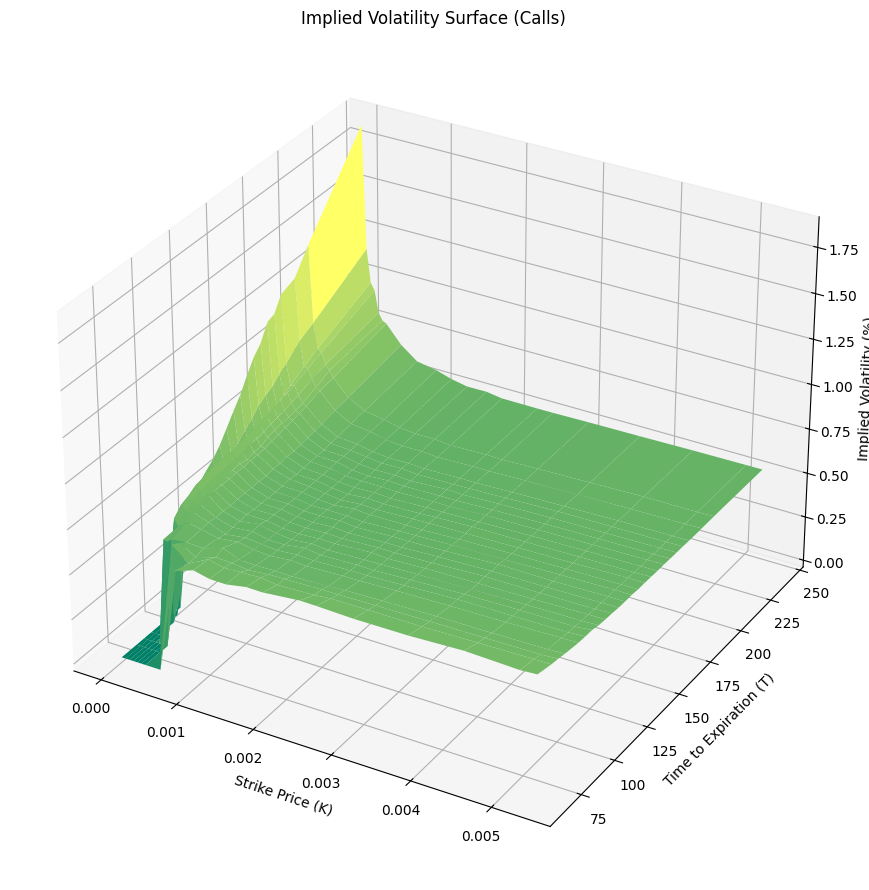

In [6]:
# calls
K, T, iv = call['strike'],  call['T'], call['impliedVolatility']
values = call[['strike', 'T', 'impliedVolatility']].pivot_table(values='impliedVolatility',index='strike',columns='T').dropna()
x, y, z = values.columns, values.index, values.values
X, Y = np.meshgrid(x, y)
#grid_points = (K, T)
#interp_iv = interpn(vals_array[1:3], iv, grid_points ,bounds_error=False, fill_value=None)
###
#vals_array

fig = plt.figure(figsize=(20,9))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(X, Y, z, cmap='summer')

# labels and title
ax.set_ylabel('Strike Price (K)')
ax.set_xlabel('Time to Expiration (T)')
ax.set_zlabel('Implied Volatility (%)')
ax.set_title('Implied Volatility Surface (Calls)')
#ax.view_init(elev=30, azim=240)
plt.tight_layout()

plt.show()

## Local Volatility Surface

add Dupire’s equation in LaTex

In [7]:
# Initialize C using Black-Scholes, Output Jax-Compatiable Values
def black_scholes1(S, K, T, r, sigma, type='call'):
    d1 = (jnp.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * jnp.sqrt(T))
    d2 = d1 - sigma * jnp.sqrt(T)
    if type == 'call':
        return S * norm.cdf(d1) - K * jnp.exp(-r * T) * norm.cdf(d2)
    if type == 'put':
        return K * jnp.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Parameters
steps = 100
S0 = today_price     # Spot price
K_min, K_max = 50, 150  # Strike price range
T_min, T_max = 1e-6, 1  # Time to maturity range
r = 0.05    # Risk-free rate
sigma = 0.2 # Volatility
dT = (K_max - K_min) / steps
dK = (T_max - T_min) / steps

In [8]:
#######
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes call option pricing function
'''
'''
def black_scholes1(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
'''

'''


# Parameters
S = 100   # Spot price
T = 0.5   # Time to maturity (in years)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility

# Range of strike prices K
K_vals = np.linspace(80, 150, 100)

# Calculate call option prices for each strike price
option_prices = [black_scholes1(S, K, T, r, sigma, type='call') for K in K_vals]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(K_vals, option_prices, label="Call Option Price", color='blue')
plt.xlabel("Strike Price (K)")
plt.ylabel("Call Option Price (C)")
plt.title("Call Option Price vs. Strike Price")
plt.grid(True)
plt.legend()
plt.show()


'''


'\n\n\n# Parameters\nS = 100   # Spot price\nT = 0.5   # Time to maturity (in years)\nr = 0.05  # Risk-free rate\nsigma = 0.2  # Volatility\n\n# Range of strike prices K\nK_vals = np.linspace(80, 150, 100)\n\n# Calculate call option prices for each strike price\noption_prices = [black_scholes1(S, K, T, r, sigma, type=\'call\') for K in K_vals]\n\n# Plotting\nplt.figure(figsize=(8, 6))\nplt.plot(K_vals, option_prices, label="Call Option Price", color=\'blue\')\nplt.xlabel("Strike Price (K)")\nplt.ylabel("Call Option Price (C)")\nplt.title("Call Option Price vs. Strike Price")\nplt.grid(True)\nplt.legend()\nplt.show()\n\n\n'

In [9]:
#########


In [10]:
### FIX ###
def fd_solve_diff(K_min, K_max, T_min, T_max, r, S0, sigma, steps):
    
    # construct domain grid
    K_vals = jnp.linspace(K_min, K_max, steps)
    T_vals = jnp.linspace(T_min, T_max, steps)
    
    # compute C using Black-Scholes
    K_mesh, T_mesh = jnp.meshgrid(K_vals, T_vals, indexing='ij')
    C = black_scholes1(S0, K_mesh, T_mesh, r, sigma)

    # functions to pass to ###autograd####
    #def C_k(K, T):
    #    return jnp.interp(K, K_vals, C[])  
    #def C_T(K, T):
    #    return jnp.interp(T, T_vals, C)
    def black_scholes(K, T, S=today_price, r=0.05, sigma=0.2):
        d1 = (jnp.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * jnp.sqrt(T))
        d2 = d1 - sigma * jnp.sqrt(T)
        return S * norm.cdf(d1) - K * jnp.exp(-r * T) * norm.cdf(d2)


    
    # partial derivatives ###(autograd)####
    dC_dK = jax.grad(black_scholes, argnums=0)  # dC/dK
    dC_dT = jax.grad(black_scholes, argnums=1)  # dC/dT
    dC_dK2 = jax.grad(dC_dK)  # d²C/dK²

    # Compute gradients at each grid point
    dC_dK_vals = jnp.array([[dC_dK(K, T) for T in T_vals] for K in K_vals])
    dC_dT_vals = jnp.array([[dC_dT(K, T) for T in T_vals] for K in K_vals])
    dC_dK2_vals = jnp.array([[dC_dK2(K, T) for T in T_vals] for K in K_vals])

    return C, K_vals, T_vals, dC_dK_vals, dC_dT_vals, dC_dK2_vals

In [11]:
%%time
C, K_vals, T_vals, dC_dK, dC_dT, dC_dK2 = fd_solve_diff(K_min, K_max, T_min, T_max, r, S0, sigma,steps)

In [12]:
C.shape

(100, 100)

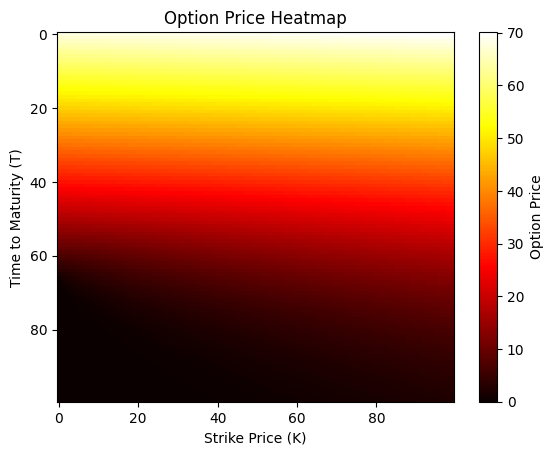

In [13]:
# Black-Scholes option price heat map
plt.imshow(C, cmap='hot', interpolation='nearest', aspect='auto')
plt.colorbar(label="Option Price")
#plt.xticks(range(len(K_vals)), K_vals)
#plt.yticks(range(len(T_vals)), T_vals)
plt.xlabel("Strike Price (K)")
plt.ylabel("Time to Maturity (T)")
plt.title("Option Price Heatmap")
plt.show()

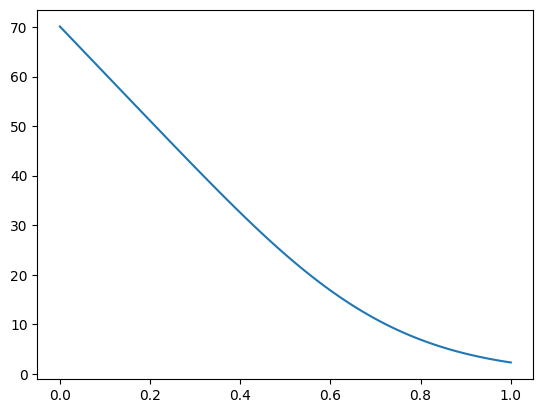

In [14]:
plt.plot(T_vals, C[:,100])
plt.show()

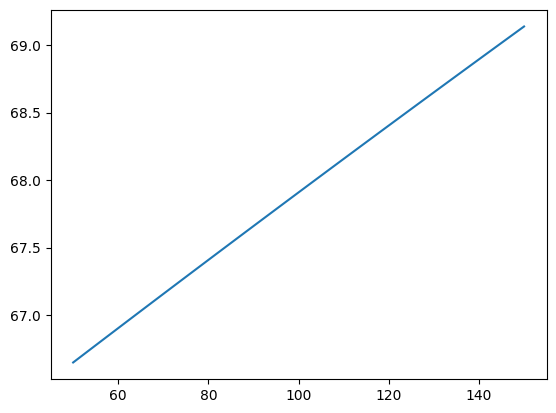

In [15]:
plt.plot(K_vals, C[1,:])
plt.show()

(100, 100)


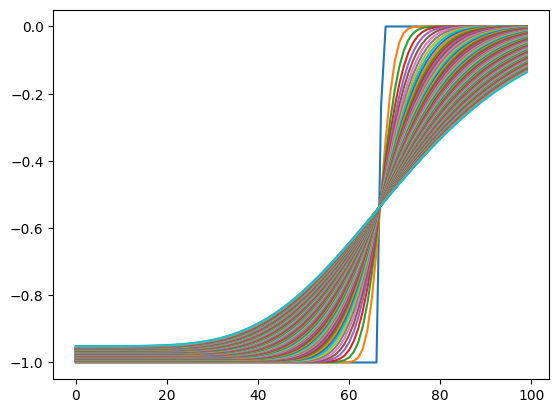

In [16]:
print(dC_dK.shape)
plt.plot(dC_dK)
plt.show()

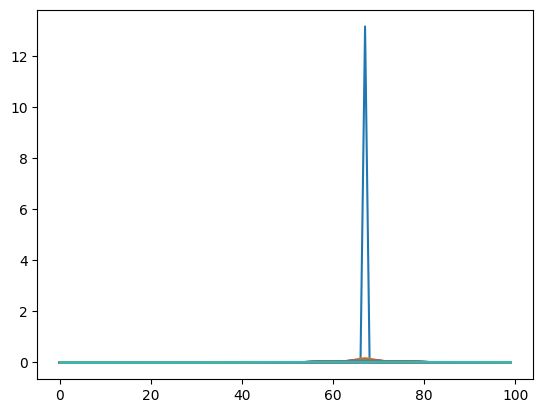

In [17]:
plt.plot(dC_dK2)
plt.show()

In [18]:
# Input Values into Dupire’s equation
sigma_local = np.zeros_like(C)
for i, K in enumerate(K_vals):  
    for j, T in enumerate(T_vals):
        denom = 0.5 * (K**2) * dC_dK2[i, j]
        if abs(denom) < 1e-6:
            sigma_local[i, j] = 0
            continue

        num = dC_dT[i, j] + r * K * dC_dK[i, j]
        sigma_local[i, j] = np.sqrt(max(num / denom, 0))


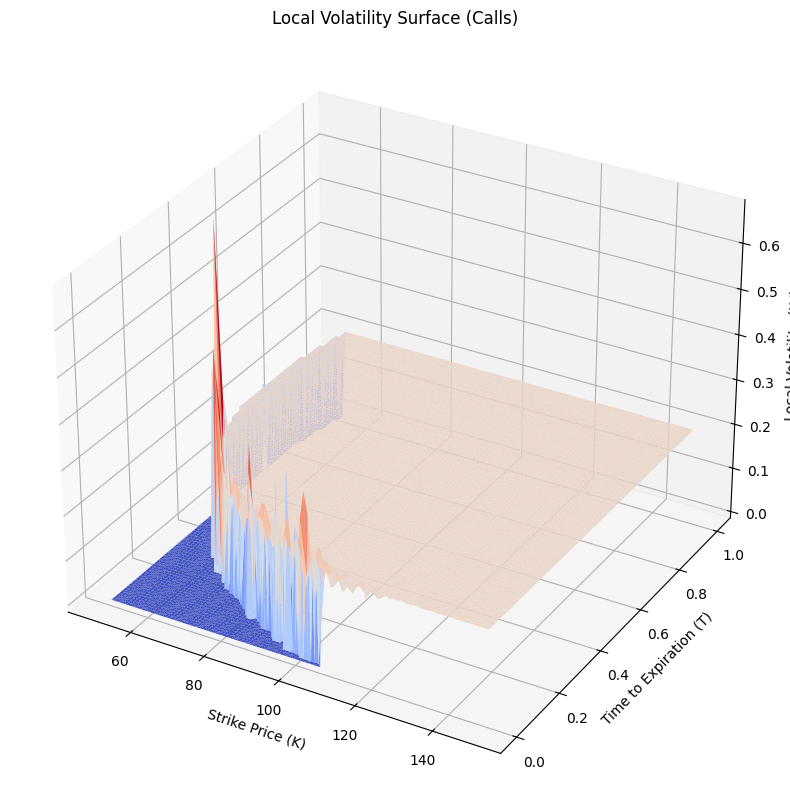

In [19]:
# plot results
K_vals_mesh, T_vals_mesh = np.meshgrid(K_vals, T_vals)

fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')

surf = ax.plot_trisurf(K_vals_mesh.ravel(), T_vals_mesh.ravel(), sigma_local.ravel(), cmap='coolwarm',
                       linewidth=0.1, antialiased=True)

# labels and title
ax.set_xlabel('Strike Price (K)')
ax.set_ylabel('Time to Expiration (T)')
ax.set_zlabel('Local Volatility (LV)')
ax.set_title('Local Volatility Surface (Calls)')

plt.show()

## Monte Carlo Simulations: Local Volatility and Black-Scholes (Call Options)

Approach: run monte carlo sim for initial conditions of NVDA options

In [20]:
call

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expirationDate,dte,T,option_type
0,NVDA250207C00050000,2025-02-03 15:31:29+00:00,50.0,66.48,65.70,66.35,-7.669998,-10.343895,9.0,83.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
1,NVDA250207C00055000,2025-02-03 15:16:13+00:00,55.0,59.10,60.65,61.35,-8.700005,-12.831865,5.0,39.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
2,NVDA250207C00060000,2025-01-31 20:57:27+00:00,60.0,59.98,55.75,56.35,0.000000,0.000000,113.0,128.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
3,NVDA250207C00065000,2025-01-31 15:39:27+00:00,65.0,61.35,50.75,51.40,0.000000,0.000000,2.0,8.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
4,NVDA250207C00070000,2025-02-03 14:51:01+00:00,70.0,44.10,46.00,46.55,-6.700001,-13.188978,21.0,500.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7672,NVDA270115C00260000,2025-02-03 15:31:29+00:00,260.0,10.58,10.35,10.55,-1.220000,-10.338985,50.0,2807.0,0.557622,False,REGULAR,USD,2027-01-15,1.945205,0.005329,Call
7673,NVDA270115C00270000,2025-02-03 14:40:02+00:00,270.0,9.37,9.60,9.85,-2.200000,-19.014692,5.0,1310.0,0.558324,False,REGULAR,USD,2027-01-15,1.945205,0.005329,Call
7674,NVDA270115C00280000,2025-02-03 15:21:13+00:00,280.0,8.69,9.00,9.25,-1.510000,-14.803925,58.0,1581.0,0.560216,False,REGULAR,USD,2027-01-15,1.945205,0.005329,Call
7675,NVDA270115C00290000,2025-02-03 15:35:42+00:00,290.0,8.58,8.30,8.55,-0.920000,-9.684212,170.0,12379.0,0.559025,False,REGULAR,USD,2027-01-15,1.945205,0.005329,Call


### Local Volatility

In [21]:
call_sample = call[call['strike'].isin(selected_strikes)].drop_duplicates(subset='strike')
print(f"K_min = {call_sample['strike'].min()}, K_max = {call_sample['strike'].max()}")
print(f"T_min = {call_sample['T'].min()}, T_max = {call_sample['T'].max()}")
call_sample

K_min = 8.0, K_max = 2050.0
T_min = 2.251829611559392e-05, T_max = 0.0010208294239069245


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expirationDate,dte,T,option_type
5,NVDA250207C00075000,2025-02-03 15:10:01+00:00,75.0,40.25,40.80,41.30,-4.950001,-10.951328,1.0,384.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
21,NVDA250207C00103000,2025-02-03 15:21:16+00:00,103.0,14.20,13.55,13.80,-3.250001,-18.624647,84.0,281.0,0.000010,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
30,NVDA250207C00112000,2025-02-03 15:39:37+00:00,112.0,6.30,6.25,6.35,-3.700000,-36.999996,5544.0,1289.0,0.463384,True,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
36,NVDA250207C00118000,2025-02-03 15:39:55+00:00,118.0,3.10,3.00,3.05,-2.700000,-46.153847,21594.0,4026.0,0.572270,False,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
43,NVDA250207C00125000,2025-02-03 15:40:03+00:00,125.0,1.07,1.10,1.08,-1.560000,-59.090908,39941.0,46436.0,0.638187,False,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
54,NVDA250207C00136000,2025-02-03 15:38:24+00:00,136.0,0.20,0.20,0.21,-0.440000,-68.750000,3322.0,10816.0,0.730471,False,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
55,NVDA250207C00137000,2025-02-03 15:39:07+00:00,137.0,0.18,0.17,0.18,-0.380000,-67.857140,3957.0,40737.0,0.737307,False,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
58,NVDA250207C00140000,2025-02-03 15:39:25+00:00,140.0,0.14,0.13,0.14,-0.270000,-67.500000,15175.0,66781.0,0.783205,False,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
63,NVDA250207C00145000,2025-02-03 15:40:25+00:00,145.0,0.09,0.08,0.09,-0.160000,-66.666670,6886.0,21854.0,0.847658,False,REGULAR,USD,2025-02-07,0.008219,0.000023,Call
66,NVDA250207C00148000,2025-02-03 15:36:25+00:00,148.0,0.06,0.06,0.07,-0.140000,-66.666664,703.0,11209.0,0.882814,False,REGULAR,USD,2025-02-07,0.008219,0.000023,Call


In [22]:
# new ranges for prediction purposes
K_min, K_max = 0, call_sample['strike'].max()
T_min, T_max = 0,  call_sample['T'].max()
K_vals = np.linspace(K_min, K_max, 100)
T_vals = np.linspace(T_min, T_max, 100)

dt = 1/365        # 1 day step size
steps = int(T // dt)
r = 0.05
interp_sigma = RegularGridInterpolator((K_vals, T_vals), sigma_local, bounds_error=True, fill_value=0)

In [23]:
def mc_sim_lv(steps, S0, r, K, T, dt, chunk_size):
    S = np.zeros((chunk_size, steps + 1))
    S[:, 0] = S0
    np.random.seed()

    for t in range(1, steps + 1):
        # clip for proper domain
        K_interp = np.clip(S[:, t-1], K_vals.min(), K_vals.max())
        T_remaining = T - (t-1)*dt
        # clip for proper domain
        T_remaining = np.clip(T_remaining, T_vals.min(), T_vals.max())
        # interpolate sigma
        sigma = interp_sigma(np.vstack((K_interp, np.full_like(K_interp, T_remaining))).T)
        # replace nans with mean
        sigma = np.nan_to_num(sigma, nan=np.mean(sigma[~np.isnan(sigma)]))

        # Euler-Maruyama step
        Z = np.random.randn(chunk_size)
        drift = (r - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt) * Z
        S[:, t] = S[:, t-1] * np.exp(drift + diffusion)
    
    return S

In [24]:
def nvda_sim_lv(data=call_sample, num_sims=10000):
    
    num_cores = multiprocessing.cpu_count()
    chunk_size = num_sims // num_cores
    simulated_prices = []
    strikes = []
    symbols = []
    for index, row in data.iterrows():
        stock.index = stock.index.tz_localize(None)

        start_date = pd.to_datetime('today')
        S0 = today_price 

        #S[:, 0] = S0
        symbol = row['contractSymbol'] # contract symbol
        K = row['strike']
        T = (pd.to_datetime(row['expirationDate']) - pd.to_datetime('today')).days / 365  # time to expiration in years
        #S_list = Parallel(n_jobs=num_cores)(
        #    delayed(mc_sim_lv)(steps, S0, r, K, T, dt, chunk_size) 
        #    for _ in range(num_cores)
        #)
        S_list =  [mc_sim_lv(steps, S0, r, K, T, dt, chunk_size) for _ in range(num_cores)] 
        #    for _ in range(num_cores)]
        S_array = np.concatenate(S_list, axis=0)
        
        # Compute simulated payoff
        sim_payoff = np.maximum(S_array[:, -1] - K, 0)
        C_sim = np.exp(-r * T) * np.mean(sim_payoff)
        simulated_prices.append(C_sim)
        strikes.append(K)
        symbols.append(symbol)
    predictions = pd.DataFrame({
        'Contract Symbol': symbols,
        'Strike': strikes,
        'Expiration Date': row['expirationDate'],
        'Simulated Price (LV)': simulated_prices
        
    })
    return predictions

In [25]:
%%time
predictions = nvda_sim_lv()

CPU times: user 33.1 s, sys: 263 ms, total: 33.3 s
Wall time: 33.6 s


### Black-Scholes

Make predictions with Black-Scholes

In [26]:
def black_scholes2(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    sim_call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return sim_call_price

In [27]:
def nvda_sim_bs(data=call_sample):
    simulated_prices = []
    for index, row in data.iterrows():
        # initialize
        stock.index = stock.index.tz_localize(None)
        start_date = pd.to_datetime('today')
        S0 = today_price 
        symbol = row['contractSymbol']
        K = row['strike']
        T = (pd.to_datetime(row['expirationDate']) - pd.to_datetime('today')).days / 365  # time to expiration in years
        sigma = row['impliedVolatility']
        
        # calculate C using black_scholes
        C_sim = black_scholes2(S0, K, T, r, sigma)

        simulated_prices.append(C_sim)
    predictions_bs = pd.Series(simulated_prices)
    return predictions_bs


In [28]:
predictions['Simulated Price (BS)'] = nvda_sim_bs()
predictions

,Contract Symbol,Strike,Expiration Date,Simulated Price (LV),Simulated Price (BS)
0,NVDA250207C00075000,75.0,2025-06-20,48.671790,42.69082
1,NVDA250207C00103000,103.0,2025-06-20,20.689300,14.702324
2,NVDA250207C00112000,112.0,2025-06-20,11.697944,5.9858704
3,NVDA250207C00118000,118.0,2025-06-20,5.731064,2.2950668
4,NVDA250207C00125000,125.0,2025-06-20,0.403781,0.5423908
5,NVDA250207C00136000,136.0,2025-06-20,0.000000,0.043160796
6,NVDA250207C00137000,137.0,2025-06-20,0.000000,0.033841968
7,NVDA250207C00140000,140.0,2025-06-20,0.000000,0.02177757
8,NVDA250207C00145000,145.0,2025-06-20,0.000000,0.010174334
9,NVDA250207C00148000,148.0,2025-06-20,0.000000,0.006527543


In [29]:
predictions.to_csv("predicted_nvda_options_prices.csv", index=False)